# 03 Response: plot additional results

In this notebook we create additional plots to show correspondence between the original mvGWAS results and the additional results corrected for mean connectivity and mean hemispheric differences respectively.

Last update: 2024-06-26, Jitse. S. Amelink

In [1]:
import pandas as pd
import numpy as np
import glob, os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def load_MOSTEST_sumstats(fn, out_fn=None):
    
    data = pd.read_csv(fn, sep="\t", engine="pyarrow")
    
    data = data[data["CHR"]!="CHR"]
    
    data.loc[data["CHR"] == "X", "CHR" ] = 23
    data.loc[data["CHR"] == "XY", "CHR" ] = 23
    
    data["CHROM"] = data["CHR"].astype("int32")
    data["BP"] = data["BP"].astype("int64")
    data["PVAL"] = data["PVAL"].astype("float64")
    data["Z"] = data["Z"].astype("float32")
    data["N"] = data["N"].astype("float32")
    
    data.sort_values(by=["CHR", "BP"], inplace=True)
    
    data.reset_index(drop=True, inplace=True)
    
    #get cumulative position
    data = get_cumulative_pos(data)
    
    data["LOG10P"] = -np.log10(data["PVAL"].astype("float64"))

    if out_fn is not None:
        data.to_csv(out_fn, sep="\t", compression="gzip")
    
    return data

def get_cumulative_pos(df):
    running_pos = float(0)

    cumulative_pos = []

    for chrom, group_df in df.groupby('CHROM'):
        chr_df = np.add(group_df['BP'].astype("int64"), running_pos)
        cumulative_pos.append(chr_df)
        running_pos += float(group_df['BP'].max())

    df['cumulative_pos'] = pd.concat(cumulative_pos)
    
    return df

In [3]:
def miami(df1, df2, y_dsc1, y_dsc2, title_str, alpha, figargs= {"figsize":(14,10),"dpi":150}):
    """
    Big plotting function to make a gene-based Miami plot
    """
    
    df1 = df1.loc[df1["LOG10P"] > 1, :]
    df2 = df2.loc[df2["LOG10P"] > 1, :]
    
    no_genes = len(df1)
    
    df1 = get_cumulative_pos(df1)
    df2 = get_cumulative_pos(df2)
    
    max_p = np.max([np.max(df1["LOG10P"]), np.max(df2["LOG10P"])])
    
    fig, (ax1, ax2) = plt.subplots(2, 1, 
        gridspec_kw={'height_ratios': [1, 1]},**figargs)
    plt.subplots_adjust(hspace=0.16)
    
    g = sns.scatterplot(data=df1,
                        #x=df1.index.values,
                        x="cumulative_pos",
                        y="LOG10P",
                        hue = 'CHROM',
                        palette = ['silver', 'darkslateblue'] * 12,
                        legend=None,
                        style=None,
                        s=6,
                        linewidth=0,
                        zorder=2,
                        ax=ax1,
                        edgecolor="black")     

    g = sns.scatterplot(data=df2,
                        #x=df2.index.values,
                        x="cumulative_pos",
                        y="LOG10P",
                        hue = 'CHROM',
                        palette = ['silver', 'darkslateblue'] * 12,
                        legend=None,
                        style=None,
                        s=6,
                        linewidth=0,
                        zorder=2,
                        ax=ax2,
                        edgecolor="black") 
    
    ax1.set_xticks(df1.groupby('CHROM')['cumulative_pos'].median())
    ax1.tick_params(which='major', width=0.3, length=2, labelsize=8)
    ax1.set_xticklabels(sorted(df1['CHROM'].unique()))
    ax1.set_xlabel('Chromosome')
    ax1.set_ylabel(y_dsc1)
    ax1.set_ylim([0, max_p])

    if alpha is not None:
        ax1.plot([np.min(df1["cumulative_pos"]), np.max(df1["cumulative_pos"])], [alpha, alpha], "--", color="dimgrey")
    
    ax2.set_xticks(df2.groupby('CHROM')['cumulative_pos'].median())
    ax2.set_ylim([0, max_p])
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xlabel('')
    ax2.set_xticklabels([])
    
    ax2.xaxis.set_ticks_position("top")
    ax2.set_ylabel(y_dsc2)
    
    if alpha is not None:
        ax2.plot([np.min(df2["cumulative_pos"]), np.max(df2["cumulative_pos"])], [alpha, alpha], "--", color="dimgrey")
   
    ax2.invert_yaxis()
    
    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.spines["left"].set_visible(True)
    ax1.spines["bottom"].set_visible(True)
    
    ax2.spines["top"].set_visible(True)
    ax2.spines["right"].set_visible(False)
    ax2.spines["left"].set_visible(True)
    ax2.spines["bottom"].set_visible(False)
    
    #if alpha is not None:
    #    for gene in df1[df1[y_name1] > alpha].index.values:
    #        ax1.text(df1.loc[gene, "cumulative_pos"]+1, df1.loc[gene, y_name1]+0.25, df1.loc[gene, "gene_name"], horizontalalignment='left', size='small', color='black') #, weight='semibold')
    #    for gene in df2[df2[y_name2] > alpha].index.values:
    #        ax2.text(df2.loc[gene, "cumulative_pos"]+1, df2.loc[gene, y_name2]+0.25, df2.loc[gene, "gene_name"], horizontalalignment='left', size='small', color='black') #, weight='semibold')
    
    fig.suptitle(title_str)

In [4]:
results_path = "/data/clusterfs/lag/users/jitame/SENT_CORE/geno/mostest/out"
fig_path = "/data/workspaces/lag/workspaces/lg-ukbiobank/projects/rest-multimodal/results/"

mvgwas_rebuttal = load_MOSTEST_sumstats(os.path.join(results_path, "sent_edges_mean_fc", "edges.sumstats"))
mvgwas_paper = load_MOSTEST_sumstats(os.path.join(results_path, "sent_edges", "edges.sumstats"))

/tmp/ipykernel_28922/1845898065.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cumulative_pos'] = pd.concat(cumulative_pos)
/tmp/ipykernel_28922/1845898065.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cumulative_pos'] = pd.concat(cumulative_pos)
/tmp/ipykernel_28922/473503605.py:20: UserWarning: The palette list has more values (24) than needed (23), which may not be intended.
  g = sns.scatterplot(data=df1,
/tmp/ipykernel_28922/473503605.py:34: UserWarning: The palette list has more v

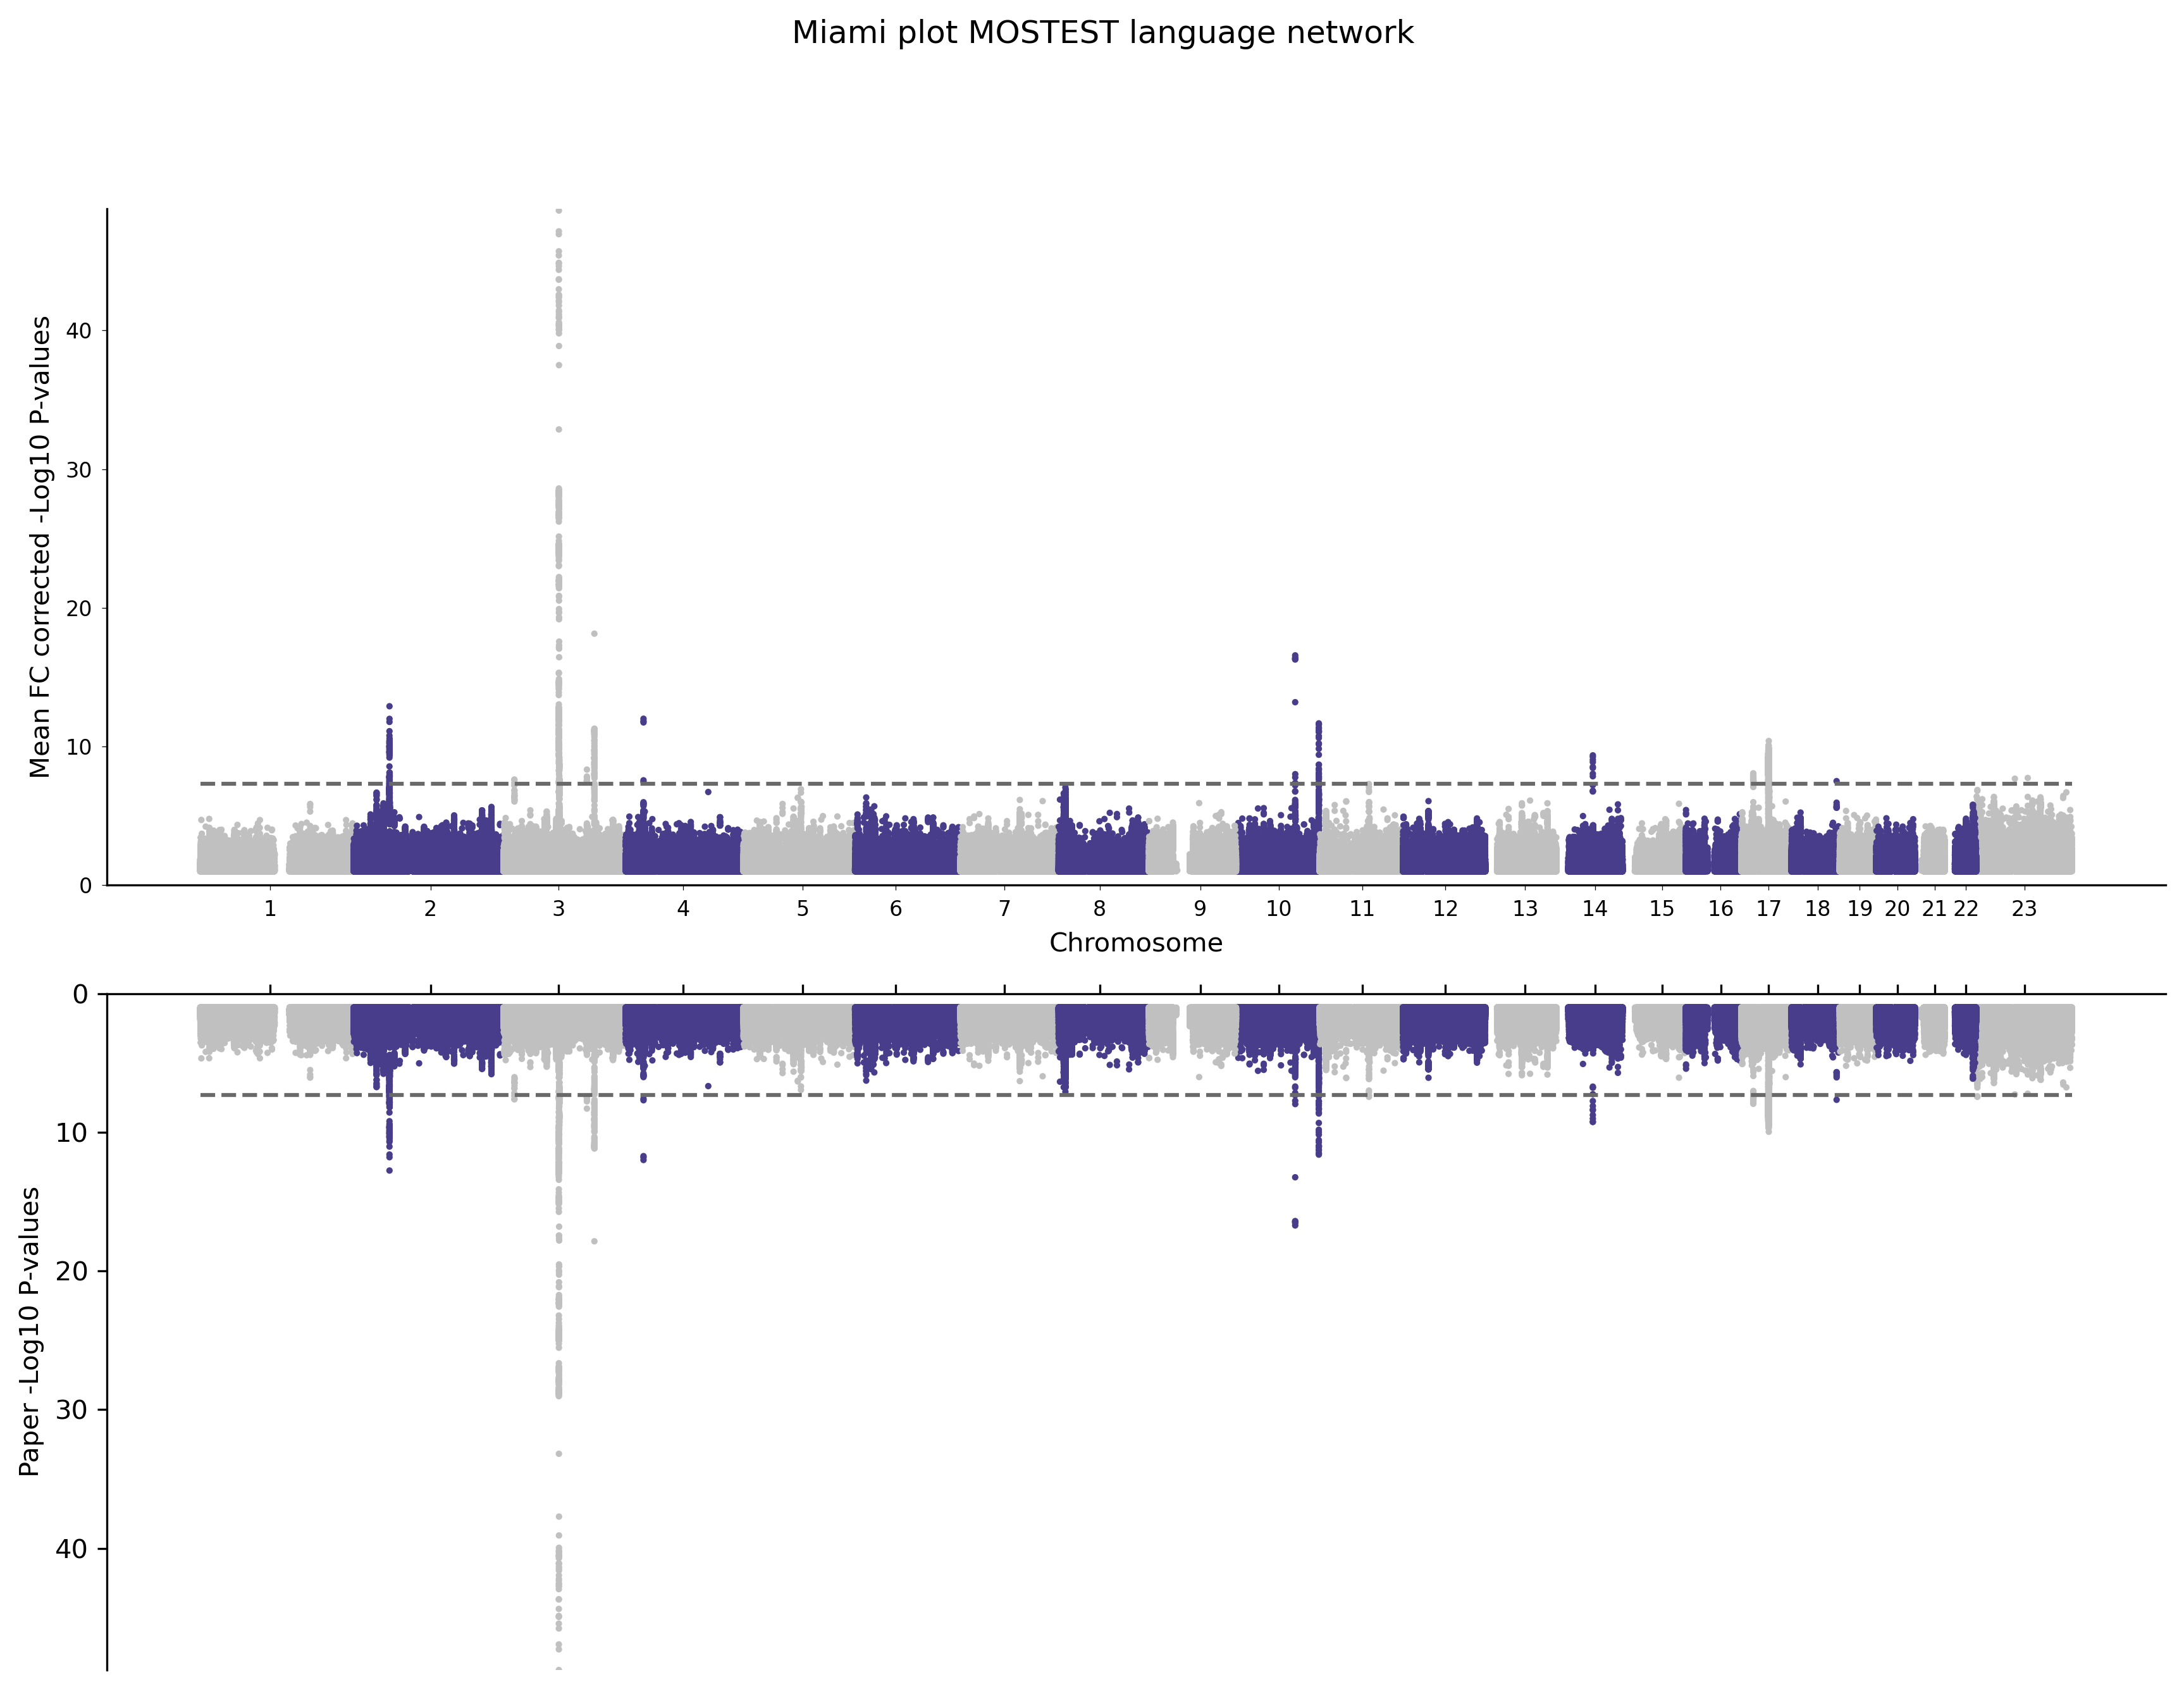

In [5]:
miami(df1 = mvgwas_rebuttal, 
      df2 = mvgwas_paper,
      y_dsc1 = "Mean FC corrected -Log10 P-values",
      y_dsc2= "Paper -Log10 P-values",
      title_str = "Miami plot MOSTEST language network",
      alpha = -np.log10(0.05/1000000),
      figargs = {"figsize":(14,10),"dpi":300})

plt.savefig(fname=os.path.join(fig_path, "Miami_mean_fc_vs_paper.png"), bbox_inches="tight")

In [6]:
def get_interesting_pref(df1, df2, alpha = -np.log10(0.05/1000000) ):
    filter_1 = df1["LOG10P"] > alpha
    filter_2 = df2["LOG10P"] > alpha
    
    combined_filter = np.logical_or(filter_1, filter_2)
    df1 = df1[combined_filter]
    df2 = df2[combined_filter]
    return df1, df2

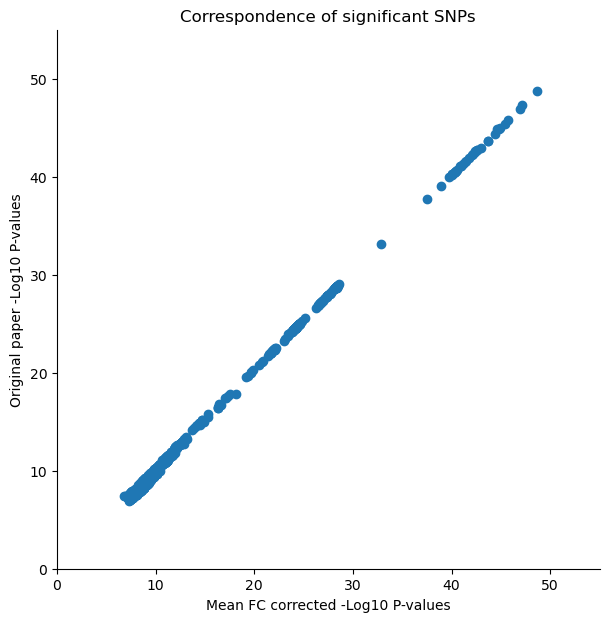

In [7]:
df1, df2 = get_interesting_pref(df1 = mvgwas_rebuttal,
                                df2 = mvgwas_paper )

fig = plt.figure(1, figsize=(7,7))
plt.scatter(x=df1["LOG10P"], y=df2["LOG10P"])
ax = plt.gca()
ax.set_xlim([0, 55])
ax.set_ylim([0, 55])

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(True)
ax.spines["bottom"].set_visible(True)

ax.set_xlabel('Mean FC corrected -Log10 P-values')
ax.set_ylabel('Original paper -Log10 P-values')

ax.set_title('Correspondence of significant SNPs')

plt.savefig(fname=os.path.join(fig_path, "Hits_comparison.png"), bbox_inches="tight")

#TODO: PLOT LINE

## Hemispheric differences 

In [8]:
results_path = "/data/clusterfs/lag/users/jitame/SENT_CORE/geno/mostest/out"
fig_path = "/data/workspaces/lag/workspaces/lg-ukbiobank/projects/rest-multimodal/results/"

mvgwas_rebuttal = load_MOSTEST_sumstats(os.path.join(results_path, "sent_edges_asym_mean_hd", "edges_asym.sumstats"))
mvgwas_paper = load_MOSTEST_sumstats(os.path.join(results_path, "sent_edges_asym", "edges_asym.sumstats"))

/tmp/ipykernel_28922/1845898065.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cumulative_pos'] = pd.concat(cumulative_pos)
/tmp/ipykernel_28922/1845898065.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cumulative_pos'] = pd.concat(cumulative_pos)
/tmp/ipykernel_28922/473503605.py:20: UserWarning: The palette list has more values (24) than needed (23), which may not be intended.
  g = sns.scatterplot(data=df1,
/tmp/ipykernel_28922/473503605.py:34: UserWarning: The palette list has more v

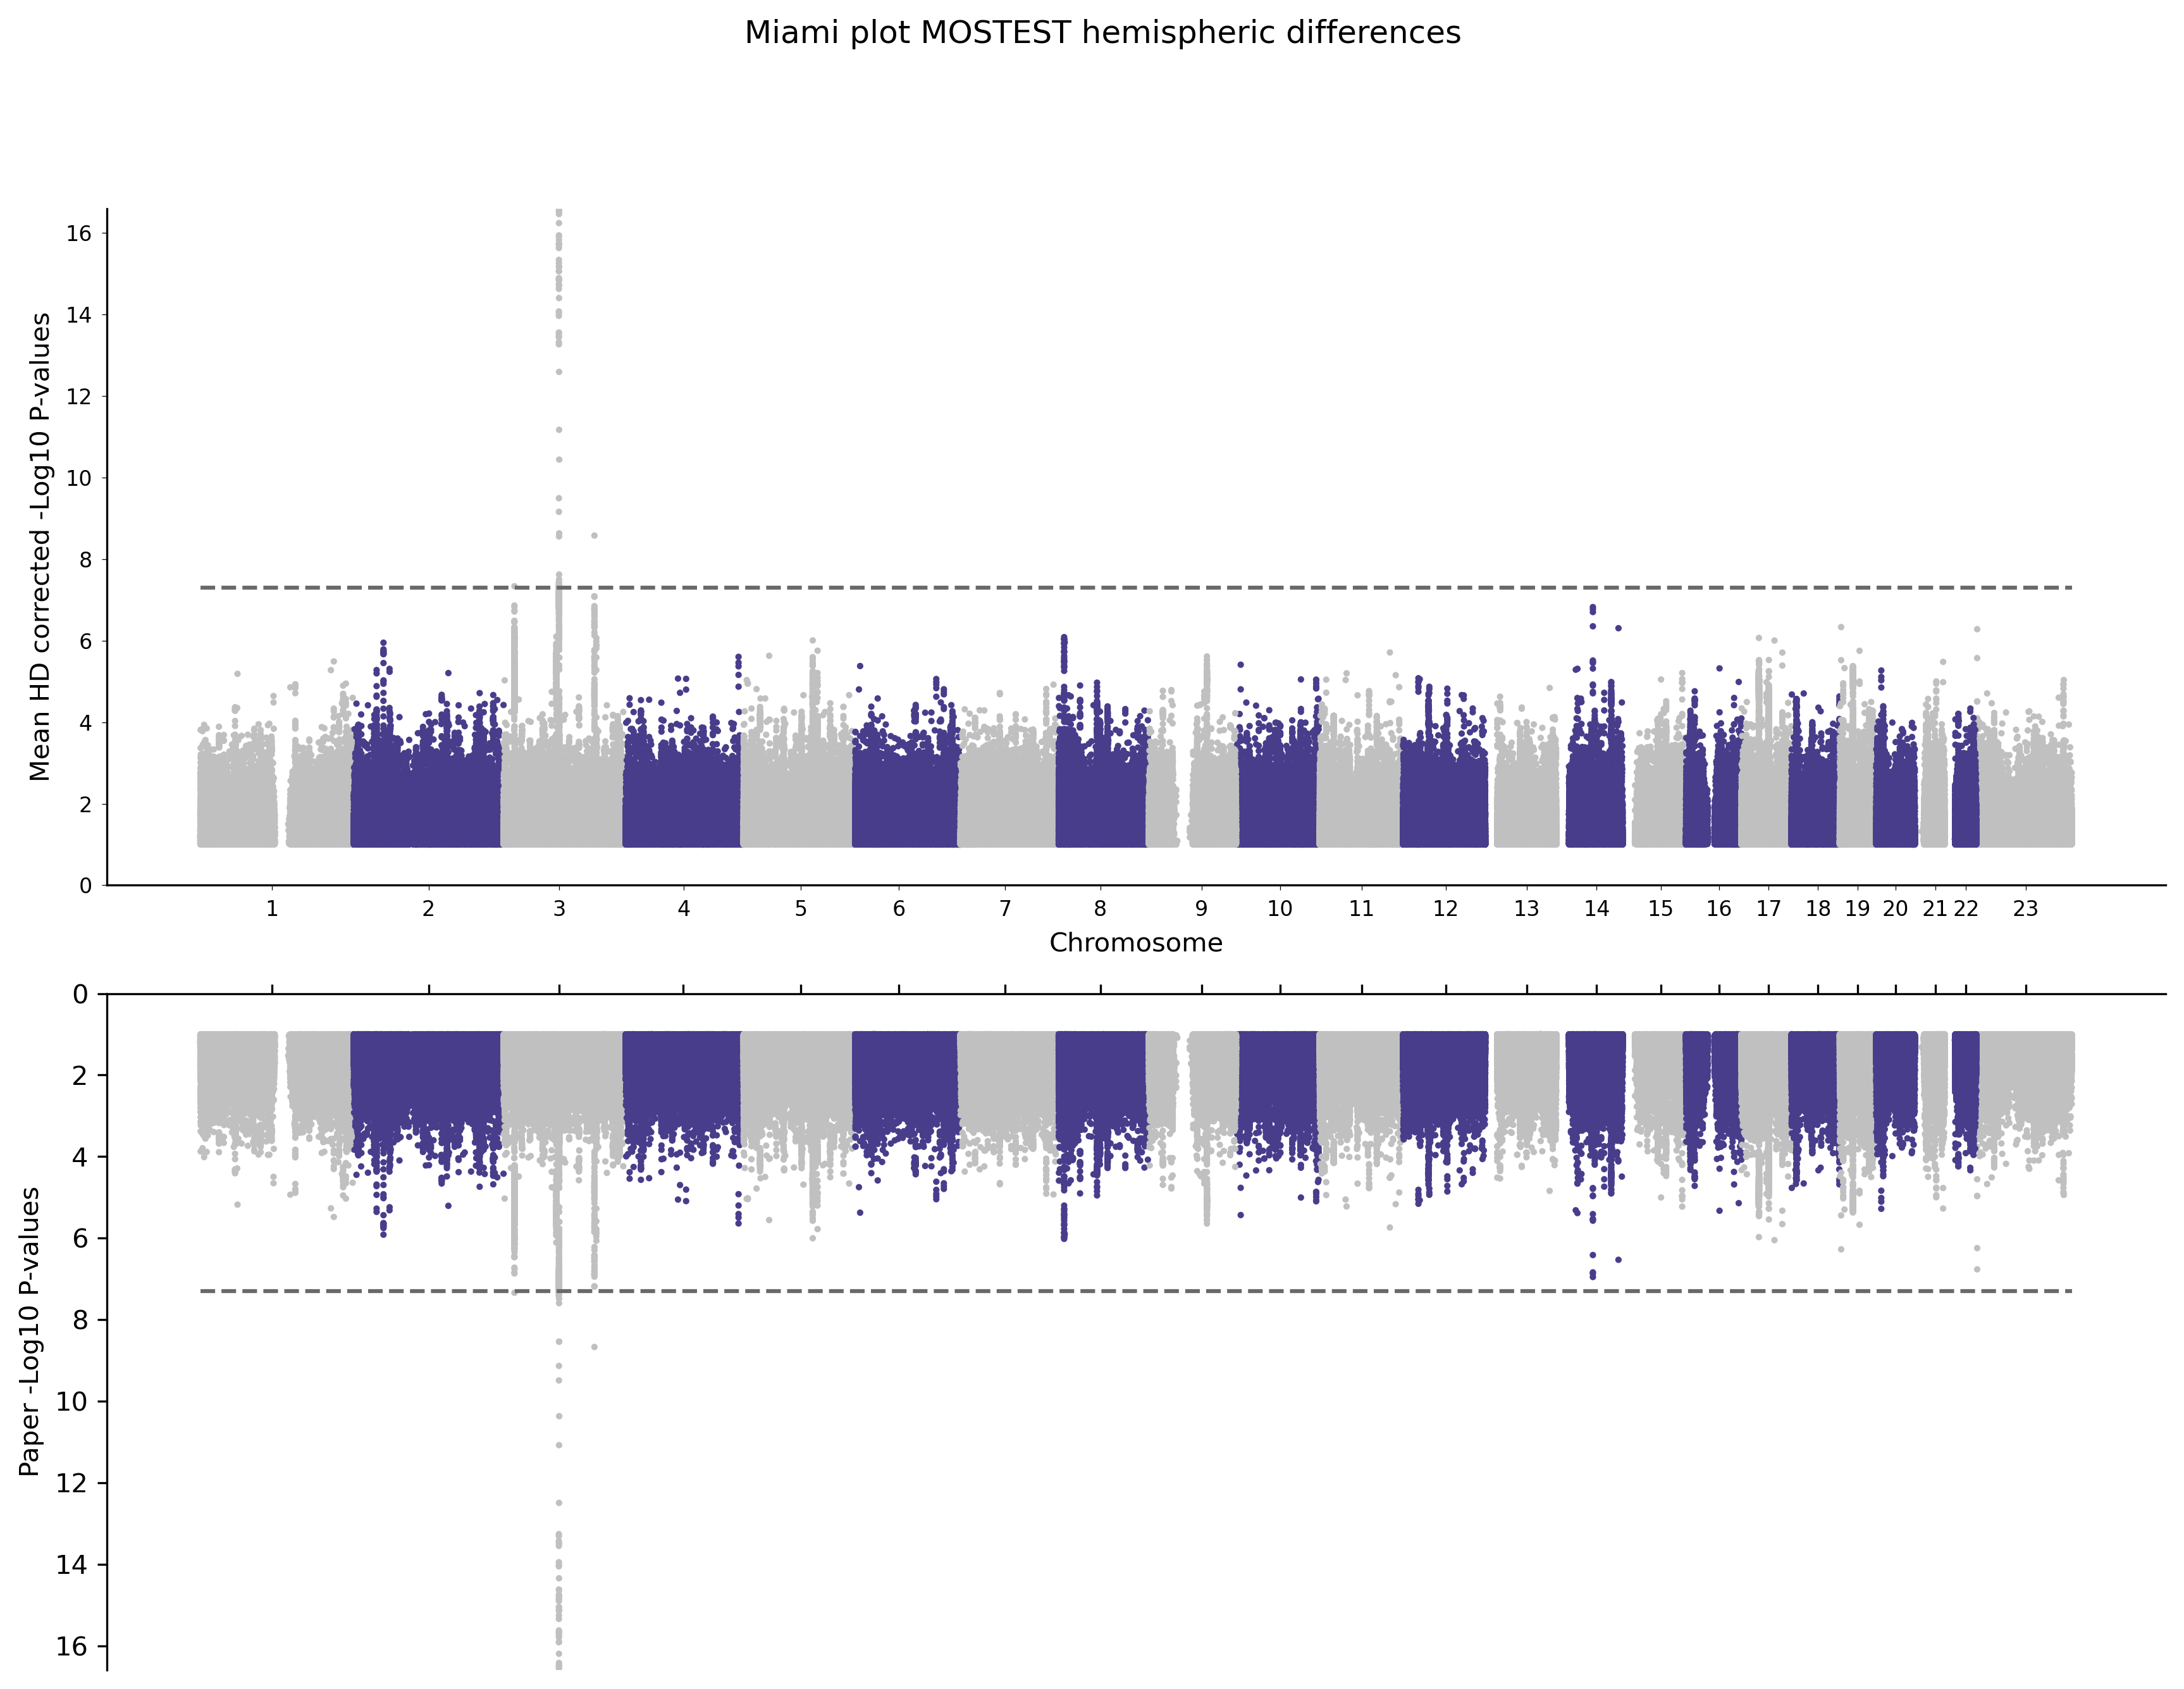

In [9]:
miami(df1 = mvgwas_rebuttal, 
      df2 = mvgwas_paper,
      y_dsc1 = "Mean HD corrected -Log10 P-values",
      y_dsc2= "Paper -Log10 P-values",
      title_str = "Miami plot MOSTEST hemispheric differences",
      alpha = -np.log10(0.05/1000000),
      figargs = {"figsize":(14,10),"dpi":300})

plt.savefig(fname=os.path.join(fig_path, "Miami_mean_HD_vs_paper.png"), bbox_inches="tight")

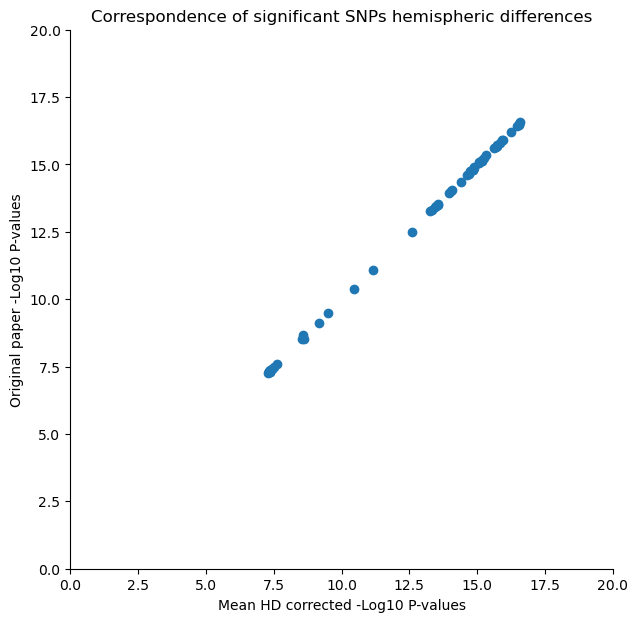

In [10]:
df1, df2 = get_interesting_pref(df1 = mvgwas_rebuttal,
                                df2 = mvgwas_paper )

fig = plt.figure(1, figsize=(7,7))
plt.scatter(x=df1["LOG10P"], y=df2["LOG10P"])
ax = plt.gca()
ax.set_xlim([0, 20])
ax.set_ylim([0, 20])

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(True)
ax.spines["bottom"].set_visible(True)

ax.set_xlabel('Mean HD corrected -Log10 P-values')
ax.set_ylabel('Original paper -Log10 P-values')

ax.set_title('Correspondence of significant SNPs hemispheric differences')

plt.savefig(fname=os.path.join(fig_path, "Hits_comparison_HD.png"), bbox_inches="tight")